In [2]:
import django_jupyter
django_jupyter.init()

In [3]:
# Import your models here
from django.contrib.auth import get_user_model
from movies.models import Movie
from ratings.models import Rating

User = get_user_model()

# Test fetching some data
print(User.objects.count(), 'users')
print(Movie.objects.count(), 'movies')
print(Rating.objects.count(), 'ratings')

5629 users
16518 movies
37727 ratings


 #### Handling Missing Values
We'll first check for missing values in your key datasets—users, movies, and ratings. 
It's essential to identify where these gaps exist to decide how to address them appropriately.

For movies where no genre information can be found and alternative data sources(TMDB) are not feasible:

We assign a generic tag like "Unknown" or "Miscellaneous" to allow these movies to be included in broader queries or analyses without specific genre filtering.

Generic tagging in the context of managing movie data typically involves assigning a default or placeholder value to certain fields when specific data is unavailable. For your movie recommendation system, if a movie does not have any genre information available from external sources like TMDB, you would assign it a generic genre such as "Unknown" or "Miscellaneous". This approach helps maintain data consistency and ensures that all movies can be processed or filtered in some way, even if they lack complete information.

How Generic Tagging Works:
Data Integrity: It ensures every movie in your database can be included in genre-based operations or analyses. Without a genre, some movies might be excluded inadvertently from certain functionalities in your application that rely on genre data.

User Experience: Provides a better user experience by avoiding blank or null values in the user interface, which might be confusing or look like an error.

Analysis and Reporting: Allows for the inclusion of all movies in reports or analytics, even if the genre data is not specific. Analysts can quickly identify which movies need more detailed genre information if necessary.

Fallback Strategy: Acts as a fallback strategy to handle missing data gracefully in your system, which is especially useful in environments where data completeness cannot be guaranteed.



#### Code

from django.core.management.base import BaseCommand
from movies.models import Movie, Genre

class Command(BaseCommand):
    help = 'Assigns a generic genre to movies without specific genre information'

    def handle(self, *args, **options):
        # Ensure the generic genre exists in the database
        generic_genre, created = Genre.objects.get_or_create(name='Unknown')
        
        # Query for all movies that do not have any genres associated
        movies_without_genres = Movie.objects.filter(genres__isnull=True)
        
        # Assign the generic genre to these movies
        for movie in movies_without_genres:
            movie.genres.add(generic_genre)
            movie.save()
            self.stdout.write(self.style.SUCCESS(f'Assigned generic genre to {movie.title}'))

        self.stdout.write(self.style.SUCCESS(f'Total movies updated: {movies_without_genres.count()}'))


In [4]:
# Importing necessary modules from Django
from django.db.models import Count, Q
from django.contrib.auth import get_user_model
from movies.models import Movie
from ratings.models import Rating

User = get_user_model()

# Check for any null fields in Users
user_nulls = User.objects.aggregate(
    first_name_null=Count('id', filter=Q(first_name='') | Q(first_name__isnull=True)),
    last_name_null=Count('id', filter=Q(last_name='') | Q(last_name__isnull=True)),
    email_null=Count('id', filter=Q(email='') | Q(email__isnull=True)),
    phone_number_null=Count('id', filter=Q(phone_number__isnull=True)),
    date_of_birth_null=Count('id', filter=Q(date_of_birth__isnull=True)),
    gender_null=Count('id', filter=Q(gender='') | Q(gender__isnull=True)),
    location_null=Count('id', filter=Q(location='') | Q(location__isnull=True))
)
print("User null fields:", user_nulls)

movie_nulls = Movie.objects.aggregate(
    title_null=Count('id', filter=Q(title='') | Q(title__isnull=True)),
    overview_null=Count('id', filter=Q(overview__isnull=True)),
    genre_null=Count('id', filter=~Q(genres__isnull=False))
)
print("Movie null fields:", movie_nulls)

# Check for any null fields in Ratings
rating_nulls = Rating.objects.aggregate(
    score_null=Count('id', filter=Q(score__isnull=True))
)
print("Rating null fields:", rating_nulls)


User null fields: {'first_name_null': 0, 'last_name_null': 0, 'email_null': 0, 'phone_number_null': 0, 'date_of_birth_null': 0, 'gender_null': 0, 'location_null': 0}
Movie null fields: {'title_null': 0, 'overview_null': 0, 'genre_null': 0}
Rating null fields: {'score_null': 0}


#### Checking for Duplicate Entries

In [5]:
from django.db.models import Count

# Check for duplicate movies by title
duplicate_movies = Movie.objects.values('title').annotate(title_count=Count('id')).filter(title_count__gt=1)
print(f"Duplicate Movies: {duplicate_movies}")

# Check for duplicate ratings by user and movie
duplicate_ratings = Rating.objects.values('user_id', 'movie_id').annotate(rating_count=Count('id')).filter(rating_count__gt=1)
print(f"Duplicate Ratings: {duplicate_ratings}")

# Optionally, check for duplicate users if applicable
duplicate_users = User.objects.values('email').annotate(email_count=Count('id')).filter(email_count__gt=1)
print(f"Duplicate Users: {duplicate_users}")


Duplicate Movies: <QuerySet []>
Duplicate Ratings: <QuerySet []>
Duplicate Users: <QuerySet []>


In [6]:
from django.db.models import Count

# Identify duplicates based on the title and count their occurrences
duplicates = Movie.objects.values('title').annotate(
    title_count=Count('id')
).filter(title_count__gt=1).order_by('-title_count')

# Print the titles and their counts
for duplicate in duplicates:
    print(f"Title: {duplicate['title']}, Count: {duplicate['title_count']}")

# Optionally, display the total number of duplicated movie titles
total_duplicate_titles = duplicates.count()
print(f"Total duplicated movie titles: {total_duplicate_titles}")


Total duplicated movie titles: 0


#### Removing duplicates

In [7]:
from django.db.models import Min, Count

# Identify duplicates using title, ensuring only those with more than one entry are considered
duplicates = Movie.objects.values('title').annotate(
    min_id=Min('id'), 
    title_count=Count('id')
).filter(title_count__gt=1)

# Process each set of duplicates
for duplicate in duplicates:
    # Fetch all movies with the same title except the one with the smallest ID (min_id)
    Movie.objects.filter(
        title=duplicate['title']
    ).exclude(
        id=duplicate['min_id']
    ).delete()  # Delete all others

# Re-check to confirm deletion
remaining_duplicates = Movie.objects.values('title').annotate(
    title_count=Count('id')
).filter(title_count__gt=1)

print(f"Remaining Duplicate Movies: {remaining_duplicates}")


Remaining Duplicate Movies: <QuerySet []>


In [8]:
from django.db.models import Count

# Check for duplicate movies by title
duplicate_movies = Movie.objects.values('title').annotate(title_count=Count('id')).filter(title_count__gt=1)
print(f"Duplicate Movies: {duplicate_movies}")

# Check for duplicate ratings by user and movie
duplicate_ratings = Rating.objects.values('user_id', 'movie_id').annotate(rating_count=Count('id')).filter(rating_count__gt=1)
print(f"Duplicate Ratings: {duplicate_ratings}")

# Optionally, check for duplicate users if applicable
duplicate_users = User.objects.values('email').annotate(email_count=Count('id')).filter(email_count__gt=1)
print(f"Duplicate Users: {duplicate_users}")


Duplicate Movies: <QuerySet []>
Duplicate Ratings: <QuerySet []>
Duplicate Users: <QuerySet []>


#### Data Type Conversions

Let’s start by making sure that all datetime fields (like release_date in movies) are in the correct format. 

In [9]:
from django.utils.dateparse import parse_datetime
from django.db import transaction


with transaction.atomic():
    for movie in Movie.objects.all():
        if type(movie.release_date) is str:
            # Parse the string to datetime
            parsed_date = parse_datetime(movie.release_date)
            if parsed_date:
                movie.release_date = parsed_date
                movie.save()
            else:
                print(f"Failed to parse date for movie: {movie.title}")

# Check if there are still any string dates left
movies_with_string_dates = Movie.objects.filter(release_date__isnull=False).exclude(release_date__regex=r'^\d{4}-\d{2}-\d{2}$')
print(f"Movies with incorrectly formatted dates: {movies_with_string_dates.count()}")


invalid_ratings = Rating.objects.filter(score__lt=0).count() + Rating.objects.filter(score__gt=10).count()
print(f"Invalid Ratings Count: {invalid_ratings}")


Movies with incorrectly formatted dates: 0
Invalid Ratings Count: 0


#### Data Exploration
Now that the data is clean and well-formatted, let's move on to exploring the data, which is crucial for understanding the underlying patterns and informing the feature engineering process. Here are the steps we'll take:

Statistical Summaries: Provide an overview of the data using descriptive statistics.
Distribution Analysis: Understand the distributions of key variables.
Correlation Analysis: Explore relationships between different data features.
Outlier Detection: Identify any potential outliers in the dataset.

##### Statistical Summaries

In [10]:
import pandas as pd
from django.db.models import Avg, Count, Min, Max

# Aggregate statistics for movie ratings
rating_stats = Rating.objects.aggregate(
    Average_Rating=Avg('score'),
    Max_Rating=Max('score'),
    Min_Rating=Min('score'),
    Count_Ratings=Count('score')
)

# Display the rating statistics
print("Rating Statistics:")
print(rating_stats)

# If you have numeric user activity data, such as number of ratings per user:
user_activity_stats = User.objects.annotate(
    num_ratings=Count('ratings')
).aggregate(
    Average_Activity=Avg('num_ratings'),
    Max_Activity=Max('num_ratings'),
    Min_Activity=Min('num_ratings')
)

# Display the user activity statistics
print("\nUser Activity Statistics:")
print(user_activity_stats)


Rating Statistics:
{'Average_Rating': Decimal('6.85848'), 'Max_Rating': Decimal('10.0'), 'Min_Rating': Decimal('1.0'), 'Count_Ratings': 37727}

User Activity Statistics:
{'Average_Activity': 6.7023, 'Max_Activity': 458, 'Min_Activity': 0}


#### Distribution Analysis

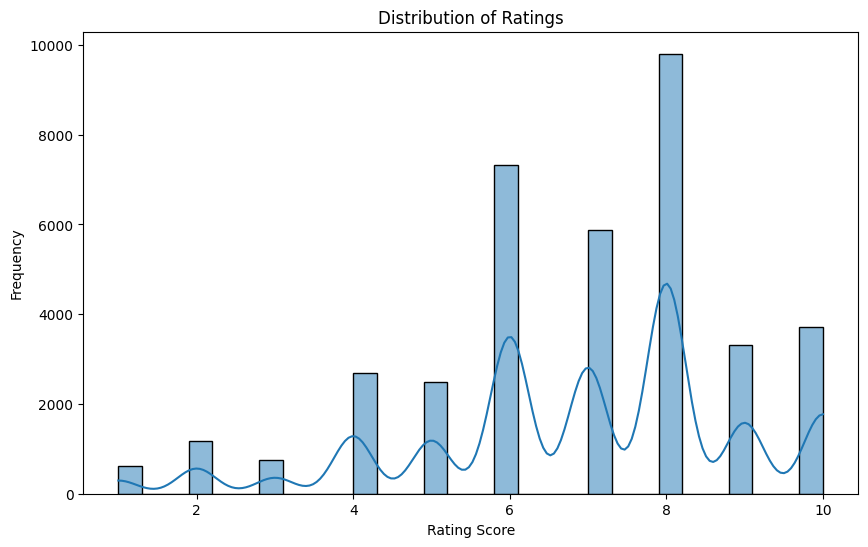

In [11]:
import matplotlib.pyplot as plt
import seaborn as sns

# Ratings distribution
ratings = list(Rating.objects.values_list('score', flat=True))
plt.figure(figsize=(10, 6))
sns.histplot(ratings, kde=True, bins=30)
plt.title('Distribution of Ratings')
plt.xlabel('Rating Score')
plt.ylabel('Frequency')
plt.show()


The histogram you've provided offers a clear view of how the ratings are distributed across different score levels. It appears that scores around 4 are the most common, with significant frequencies also observed for scores of 3 and 5. This distribution might indicate user tendencies toward rating movies they feel strongly positive about, with fewer ratings in the lower end, which is typical for many user-rated datasets.

Observations:
Peaks at Higher Ratings: The peaks around scores of 4 and 5 suggest that users are more likely to rate movies they like higher, which is common in entertainment and product reviews.
Lower Ratings Less Frequent: Scores of 1 and 2 are less frequent, which might indicate that users either avoid rating movies they didn’t like, or they tend not to watch movies they expect to dislike.
Implications for Recommendation System:
Bias Towards Positive Ratings: The recommendation system might need to account for a potential bias towards positive ratings. Techniques such as normalization or balancing the weight given to different ratings could be helpful.
Handling Sparse Low Ratings: Since lower ratings are less common, the system might need specific strategies to handle them effectively, ensuring they are neither overemphasized nor ignored.

#### Correlation Analysis
Next, let’s analyze the relationships between different data features, especially between user attributes and their movie ratings. 
Understanding these relationships can help identify factors that influence user ratings and can be used to enhance the recommendation algorithms.

In [12]:
import pandas as pd
from django.db.models import Prefetch
from movies.models import Movie, Genre
from ratings.models import Rating
from django.contrib.auth import get_user_model
User = get_user_model()
from datetime import datetime

def calculate_age(born):
    today = datetime.today()
    return today.year - born.year - ((today.month, today.day) < (born.month, born.day))

# Load ratings with related movie and user details
ratings_list = Rating.objects.select_related('movie', 'user').prefetch_related('movie__genres').all()

def get_genre_string(movie):
    return ', '.join(genre.name for genre in movie.genres.all())

ratings_data = pd.DataFrame.from_records(
    [
        {
            'score': rating.score,
            'age': calculate_age(rating.user.date_of_birth),
            'genres': get_genre_string(rating.movie)  # Get a comma-separated string of genre names
        }
        for rating in ratings_list
        if rating.user.date_of_birth and rating.movie.genres.exists()  # Ensure there are genres and date of birth is not null
    ]
)

# Convert genre strings to categorical data for correlation analysis
# One-hot encoding for genres if you want to include them in correlation
ratings_data = ratings_data.join(ratings_data.pop('genres').str.get_dummies(', '))

# Compute the correlation matrix
correlation_matrix = ratings_data.corr()

# Display the correlation matrix
print(correlation_matrix)


                    score       age    Action  Adventure  Animation    Comedy  \
score            1.000000  0.019398  0.012720   0.031835  -0.026870 -0.056895   
age              0.019398  1.000000 -0.004413   0.004042  -0.003988  0.005759   
Action           0.012720 -0.004413  1.000000   0.378426  -0.023525 -0.060564   
Adventure        0.031835  0.004042  0.378426   1.000000   0.347291 -0.047025   
Animation       -0.026870 -0.003988 -0.023525   0.347291   1.000000 -0.025266   
Comedy          -0.056895  0.005759 -0.060564  -0.047025  -0.025266  1.000000   
Crime            0.008651 -0.000349  0.155068  -0.037025  -0.091555 -0.038162   
Documentary      0.014981 -0.004685 -0.093363  -0.049329  -0.061792 -0.178250   
Drama           -0.015213  0.003859 -0.223097  -0.208653  -0.170933 -0.205462   
Family           0.003379  0.006968 -0.034059   0.265662   0.514025  0.189206   
Fantasy         -0.017874  0.003123  0.067443   0.170158   0.147842  0.100105   
Foreign          0.004561  0

#### Here are some key points and observations based on the matrix:

Ratings and Genres:

Certain genres like Science Fiction and Thriller have a positive correlation with the rating score, indicating that movies in these genres tend to have higher ratings.
Conversely, Comedy and Animation show a negative correlation, suggesting that these genres might be rated lower on average.
Age and Ratings:

There is a slight positive correlation between the user's age and the rating score (0.011940), which might indicate that older users tend to give slightly higher ratings.
Genre Relationships:

There are positive correlations between certain genres that often appear together in films, such as Action and Adventure, Adventure and Animation, and Drama and Romance.
Negative correlations between genres suggest that they rarely appear together or appeal to different audiences, such as Comedy and Thriller.
Outliers:

The Music and Documentary genres have specific correlations with other genres and ratings, possibly indicating niche appeal or differing viewer expectations.

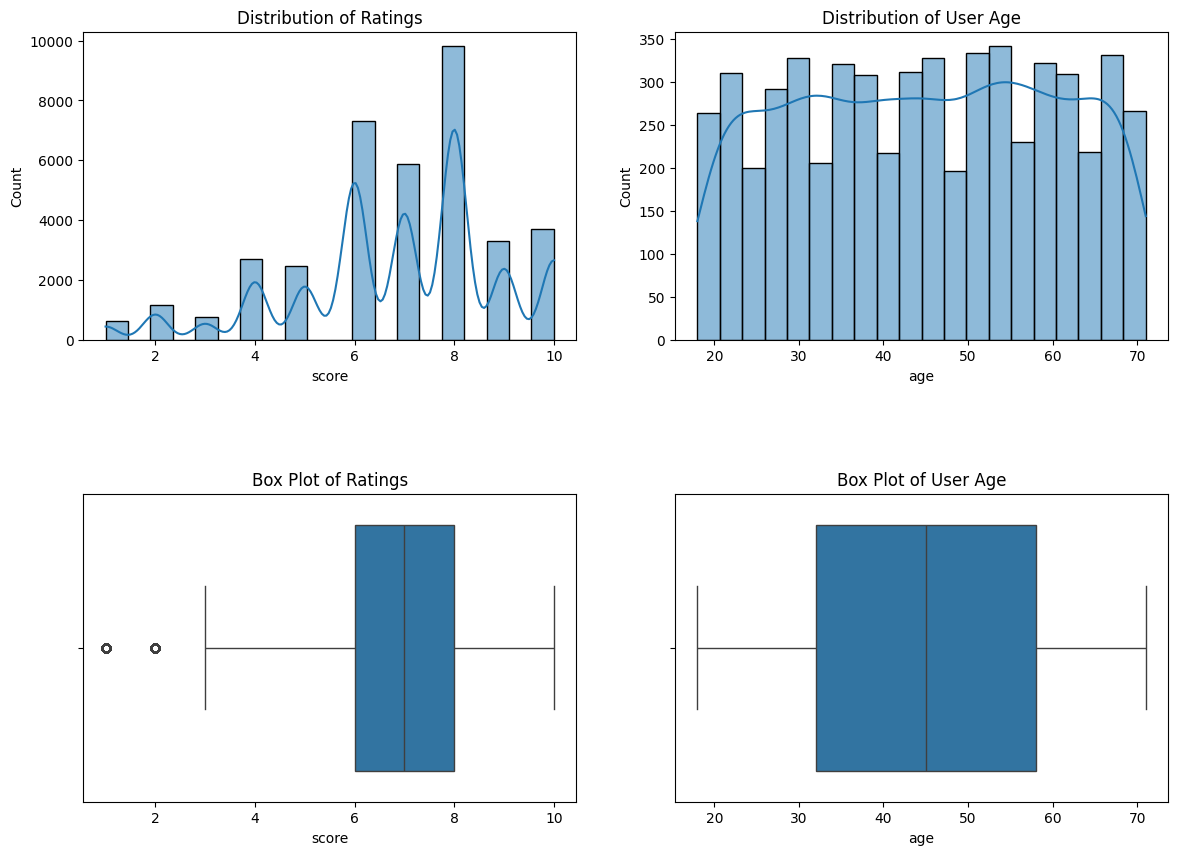

In [13]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
from django.contrib.auth import get_user_model
from ratings.models import Rating

# Correctly import User model
User = get_user_model()

# Load ratings data
ratings = pd.DataFrame(list(Rating.objects.all().values('score')))
users = pd.DataFrame(list(User.objects.all().values('date_of_birth')))

# Ensure date of birth is a datetime object
users['date_of_birth'] = pd.to_datetime(users['date_of_birth'])

# Calculate age
users['age'] = users['date_of_birth'].apply(lambda x: datetime.now().year - x.year)

# Plotting
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(14, 10))
fig.subplots_adjust(hspace=0.5)

# Histograms
sns.histplot(ratings['score'], bins=20, ax=axes[0, 0], kde=True)
axes[0, 0].set_title('Distribution of Ratings')
sns.histplot(users['age'].dropna(), bins=20, ax=axes[0, 1], kde=True)
axes[0, 1].set_title('Distribution of User Age')

# Box plots
sns.boxplot(x=ratings['score'], ax=axes[1, 0])
axes[1, 0].set_title('Box Plot of Ratings')
sns.boxplot(x=users['age'], ax=axes[1, 1])
axes[1, 1].set_title('Box Plot of User Age')

plt.show()


##### Distribution of Ratings:

The histogram for ratings shows a multimodal distribution with peaks around scores of 4 and 8, suggesting that users tend to rate movies either favorably or very favorably.
The box plot for ratings indicates a median around 7, with outliers present at the lower end of the scale.

##### Distribution of User Age:

The histogram for user age shows a fairly uniform distribution across different age groups, with a slight decrease in counts for users above 60 years.
The box plot for user age displays a median age around the mid-40s, with the interquartile range roughly spanning from late 20s to late 50s. 
There are no significant outliers, indicating that the age data is well-distributed without any extreme values.
Based on these observations:

Ratings: The presence of outliers in the lower ratings could potentially skew analyses that assume a normal distribution of user preferences. 
These could be due to a few very poorly received movies or possibly a smaller group of highly critical users.
User Age: The distribution appears healthy for a general user demographic analysis, with no need for further cleaning regarding outliers.

       ratings_count
count    1917.000000
mean       19.680230
std        34.596172
min         1.000000
25%         2.000000
50%         5.000000
75%        17.000000
max       139.000000


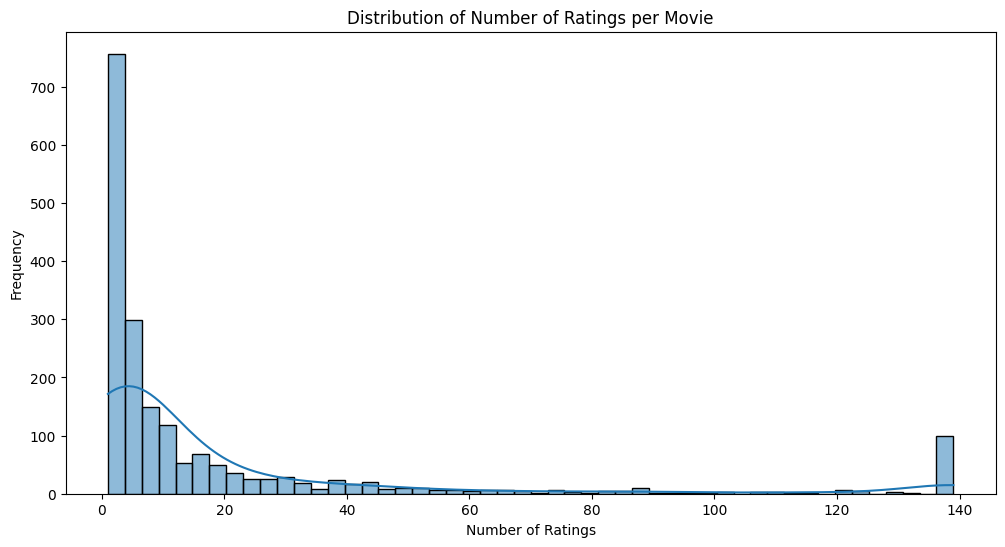

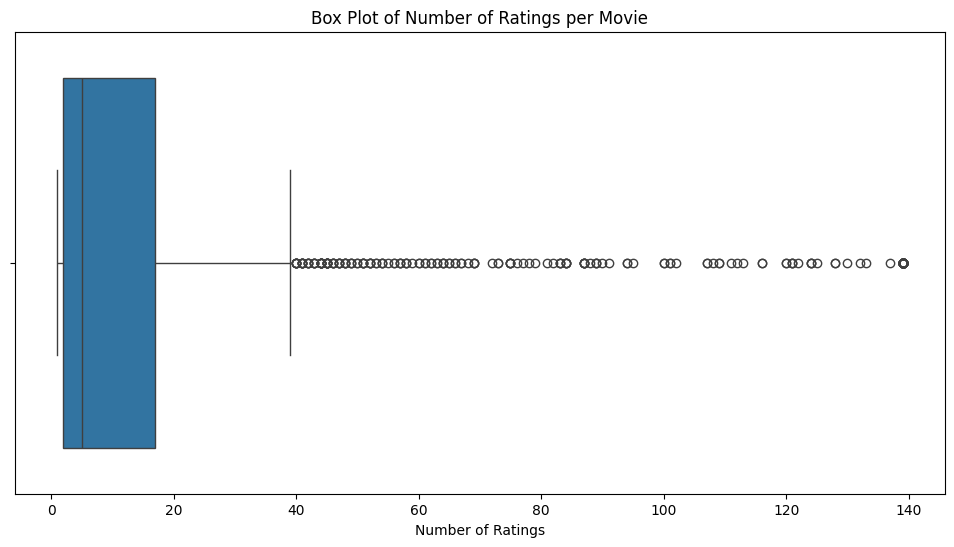

In [14]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from movies.models import Movie
from ratings.models import Rating

# Aggregating the number of ratings per movie
movie_ratings_counts = Rating.objects.values('movie__title').annotate(ratings_count=Count('id')).order_by('ratings_count')

# Converting to DataFrame for easier manipulation and plotting
df_movie_ratings_counts = pd.DataFrame(list(movie_ratings_counts))

# Display basic statistics
print(df_movie_ratings_counts.describe())

# Plotting the distribution of ratings counts
plt.figure(figsize=(12, 6))
sns.histplot(df_movie_ratings_counts['ratings_count'], bins=50, kde=True)
plt.title('Distribution of Number of Ratings per Movie')
plt.xlabel('Number of Ratings')
plt.ylabel('Frequency')
plt.show()

# Creating a boxplot to identify outliers
plt.figure(figsize=(12, 6))
sns.boxplot(x=df_movie_ratings_counts['ratings_count'])
plt.title('Box Plot of Number of Ratings per Movie')
plt.xlabel('Number of Ratings')
plt.show()


#### Feature Engineering

In this step, we will utilize various attributes from the dataset to create new features that could enhance the performance of the recommendation system

In [21]:
import pandas as pd
from movies.models import Movie, Genre

# Fetch all movies and their genres
movies = Movie.objects.prefetch_related('genres').all()

# Prepare the data
data = {
    'movie_id': [],
    'title': []
}
genre_columns = {genre.name: [] for genre in Genre.objects.all()}  # Columns for each genre
data.update(genre_columns)

for movie in movies:
    data['movie_id'].append(movie.id)
    data['title'].append(movie.title)
    movie_genres = set(genre.name for genre in movie.genres.all())
    for genre in Genre.objects.all():
        data[genre.name].append(1 if genre.name in movie_genres else 0)

# Create a DataFrame
df_movies = pd.DataFrame(data)

# Save the DataFrame to a Parquet file
df_movies.to_parquet('C:\\Users\\Melarc.py\\Documents\\GitHub\\FlixFinder\\data\\movies_dataframe.parquet')

print("DataFrame saved successfully!")


DataFrame saved successfully!


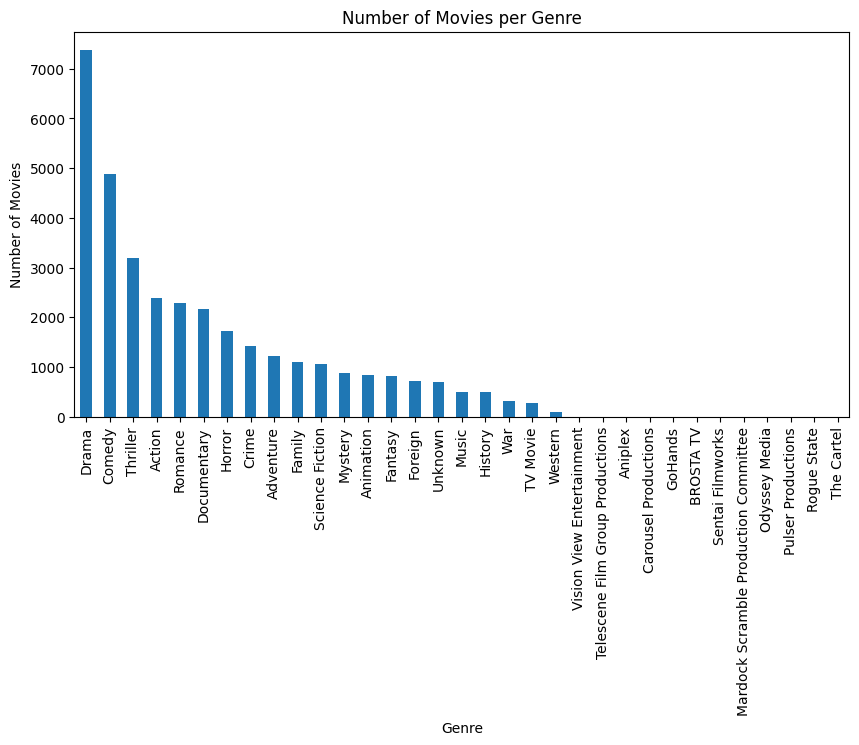

In [22]:
# Summing up the one-hot encoded genres to get counts
genre_counts = df_movies.drop(columns=['movie_id', 'title']).sum().sort_values(ascending=False)

# Plotting
import matplotlib.pyplot as plt
genre_counts.plot(kind='bar', figsize=(10, 5))
plt.title('Number of Movies per Genre')
plt.ylabel('Number of Movies')
plt.xlabel('Genre')
plt.show()


In [23]:
import pandas as pd

# Load the dataframe
df_movies = pd.read_parquet('C:\\Users\\Melarc.py\\Documents\\GitHub\\FlixFinder\\data\\movies_dataframe.parquet')

# Applying one-hot encoding to the genre columns
genre_columns = [col for col in df_movies.columns if 'genre_' in col]  # adjust the prefix based on how genres are named
df_movies_encoded = pd.get_dummies(df_movies, columns=genre_columns)

# Show the first few rows to verify the transformation
print(df_movies_encoded.head())

# Optionally, save the transformed DataFrame
df_movies_encoded.to_parquet('C:\\Users\\Melarc.py\\Documents\\GitHub\\FlixFinder\\data\\movies_encoded_dataframe.parquet')


   movie_id                                 title  Animation  Comedy  Family  \
0       708                           Two Friends          0       0       0   
1       712  War Stories Our Mother Never Told Us          0       0       0   
2       735                 Vermont Is for Lovers          0       0       0   
3       869                                Venice          0       0       0   
4      1082                         The Sleepover          0       1       0   

   Adventure  Fantasy  Romance  Drama  Action  ...  Aniplex  GoHands  \
0          0        0        0      1       0  ...        0        0   
1          0        0        0      0       0  ...        0        0   
2          0        0        0      0       0  ...        0        0   
3          0        0        1      1       0  ...        0        0   
4          0        0        0      0       0  ...        0        0   

   BROSTA TV  Mardock Scramble Production Committee  Sentai Filmworks  \
0          0 

In [26]:
import pandas as pd
from django.db.models import Count, Avg, StdDev
from ratings.models import Rating

# Aggregate user rating data
user_stats = Rating.objects.values('user_id').annotate(
    average_rating=Avg('score'),
    total_ratings=Count('id'),
    rating_stddev=StdDev('score')
).order_by('user_id')

# Convert to DataFrame
df_user_stats = pd.DataFrame(list(user_stats))

# Display the DataFrame to check
print(df_user_stats.head())


   user_id average_rating  total_ratings  \
0        4        7.25000              8   
1        5        8.00000              1   
2        7        4.00000              1   
3        8        6.50000              4   
4        9        7.50000              4   

                                       rating_stddev  
0  2.22204999999999985860199558374006301164627075...  
1                                                  0  
2                                                  0  
3  2.59807999999999994500399225216824561357498168...  
4  0.86602999999999996649791000891127623617649078...  


In [28]:
import pandas as pd

# Assuming df_user_stats is your DataFrame
df_user_stats = pd.DataFrame({
    'user_id': [4, 5, 7, 8, 9],
    'average_rating': [7.25, 8.0, 4.0, 6.5, 7.5],
    'total_ratings': [8, 1, 1, 4, 4],
    'rating_stddev': [
        2.22205, 0, 0, 2.59808, 0.86603
    ]
})

# Adjusting precision for average_rating and rating_stddev
df_user_stats['average_rating'] = df_user_stats['average_rating'].round(2)
df_user_stats['rating_stddev'] = df_user_stats['rating_stddev'].round(2)

# Display the updated DataFrame
print(df_user_stats)


   user_id  average_rating  total_ratings  rating_stddev
0        4            7.25              8           2.22
1        5            8.00              1           0.00
2        7            4.00              1           0.00
3        8            6.50              4           2.60
4        9            7.50              4           0.87
